In [38]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.circuit.library import Initialize
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_cloud", token="4PkG3WlXufZct6TqMYVREZ820GSfbt8G1RezJuKTT22O",overwrite=True)
from qiskit_aer import AerSimulator

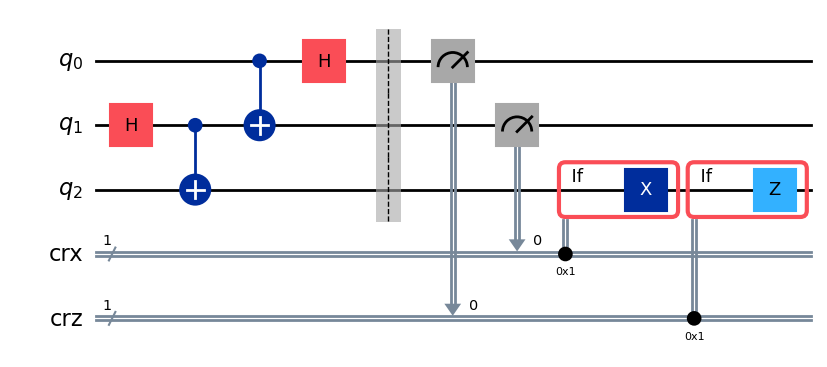

In [39]:
def create_bellstate(circuit, a, b):
    circuit.h(a)
    circuit.cx(a,b)

def alice_gates(qc, psi, a):
    qc.cx(psi,a)
    qc.h(psi)

def measure_and_send(qc,a,b):
    qc.barrier()
    qc.measure(a,1)
    qc.measure(b,0)

def bob_gates(crx,crz,qc,qubit):
    with qc.if_test((crx,1)):
        qc.x(qubit)
    with qc.if_test((crz,1)):
        qc.z(qubit)

qc=QuantumRegister(3,name='q')
crx=ClassicalRegister(1,name='crx')
crz=ClassicalRegister(1,name='crz')
teleportation_circuit=QuantumCircuit(qc,crx,crz)
create_bellstate(teleportation_circuit, 1,2)
alice_gates(teleportation_circuit, 0, 1)
measure_and_send(teleportation_circuit,0,1)
bob_gates(crx,crz,teleportation_circuit,2)
teleportation_circuit.draw('mpl')

<IPython.core.display.Latex object>

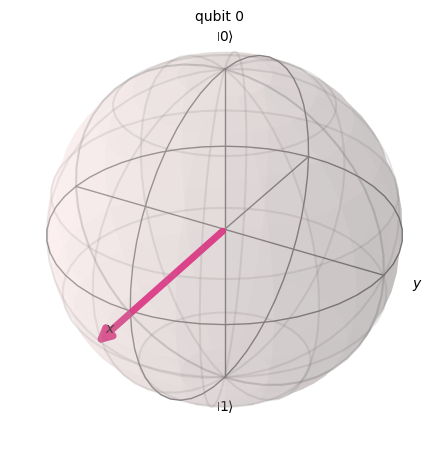

In [40]:
psi=random_statevector(2)
display(array_to_latex(psi,prefix="\\psi\\rangle ="))
plot_bloch_multivector(psi)        

In [41]:
init_gate=Initialize(psi)
init_gate.label='init'
inv_init_gate=init_gate.gates_to_uncompute()

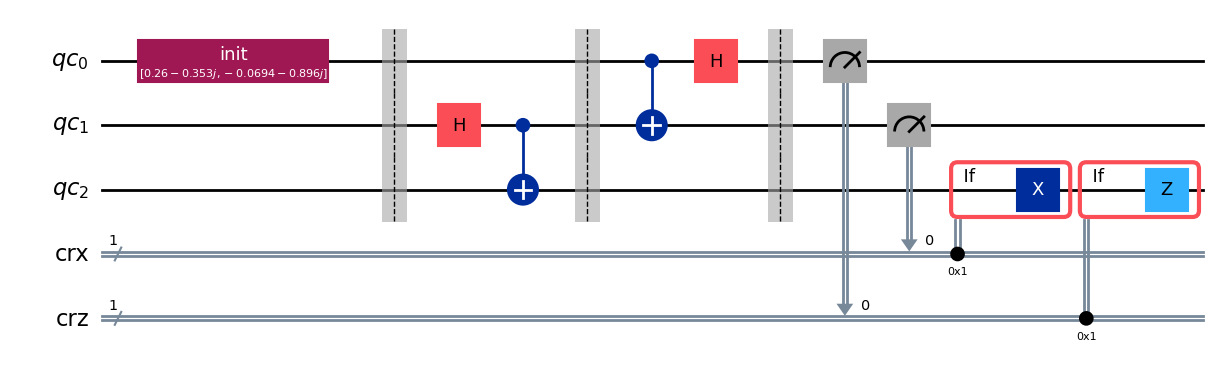

In [42]:
qr=QuantumRegister(3, name='qc')
crx=ClassicalRegister(1,name='crx')
crz=ClassicalRegister(1,name='crz')
qc=QuantumCircuit(qr,crx,crz)
qc.append(init_gate,[0])
qc.barrier()

create_bellstate(qc,1,2)
qc.barrier()

alice_gates(qc,0,1)
measure_and_send(qc,0,1)
bob_gates(crx,crz,qc,2)
qc.draw('mpl')

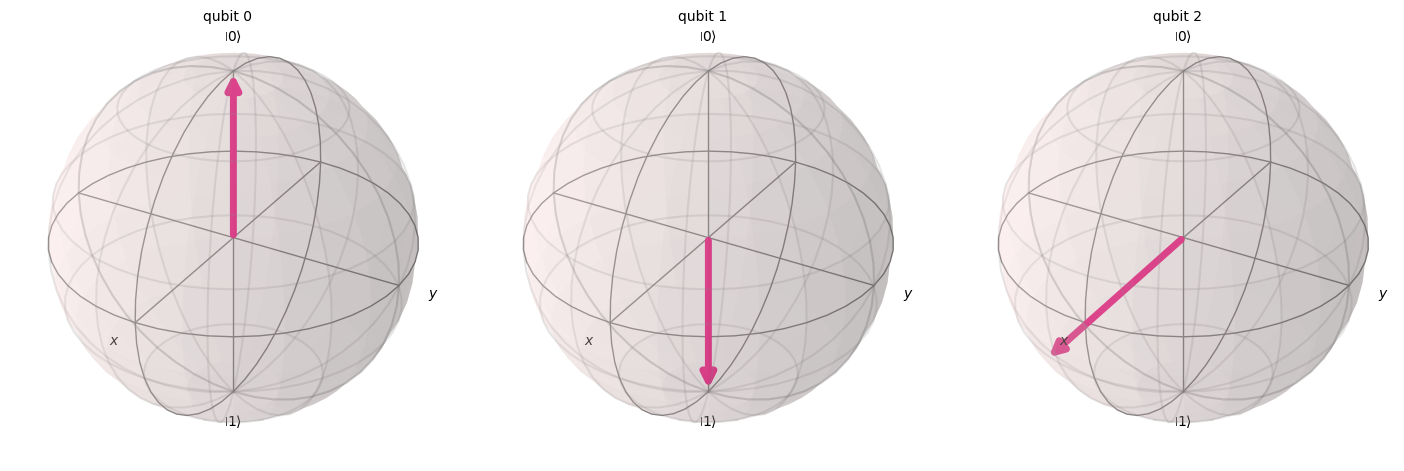

In [43]:
sim=AerSimulator()
qc.save_statevector()
out_vector=sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

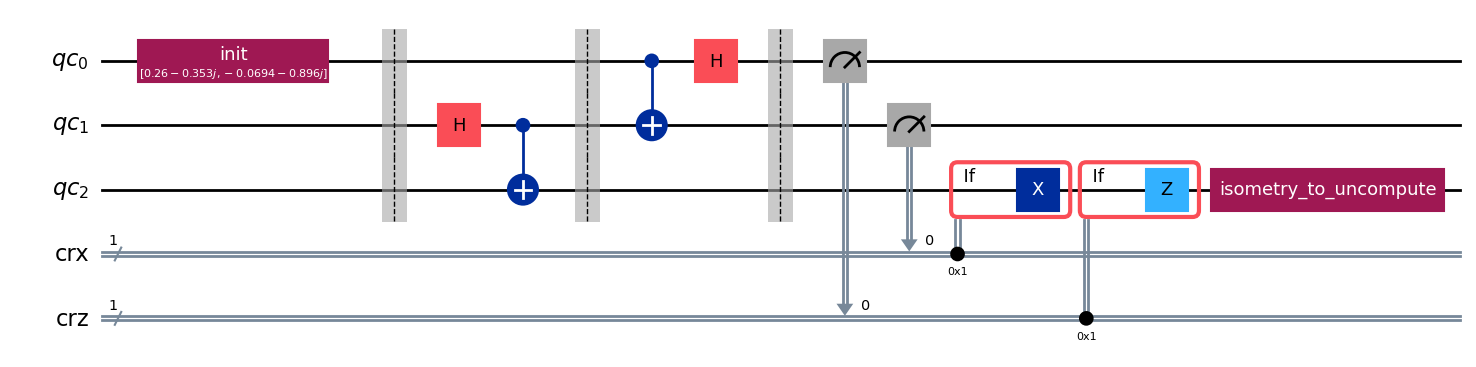

In [44]:
qr=QuantumRegister(3, name='qc')
crx=ClassicalRegister(1,name='crx')
crz=ClassicalRegister(1,name='crz')
qc=QuantumCircuit(qr,crx,crz)
qc.append(init_gate,[0])
qc.barrier()

create_bellstate(qc,1,2)
qc.barrier()

alice_gates(qc,0,1)
measure_and_send(qc,0,1)
bob_gates(crx,crz,qc,2)
qc.append(inv_init_gate, [2])
qc.draw('mpl')

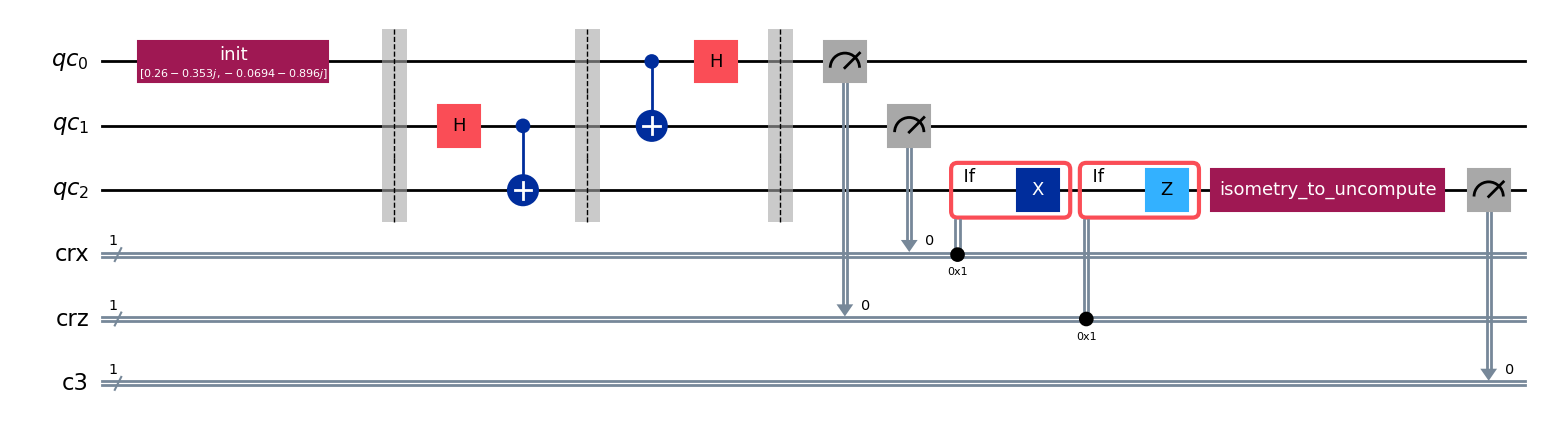

In [45]:
cr_result=ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw('mpl')

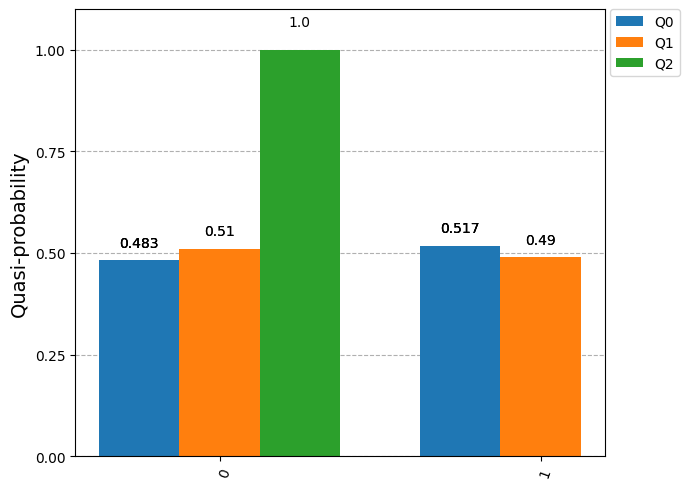

In [52]:
from qiskit import transpile
from qiskit.visualization import plot_distribution
t_qc=transpile(qc,sim)
#t_qc.save_statevector()
result=sim.run(t_qc).result()
qubit_dicts = [marginal_counts(result, indices=[i]).get_counts() for i in range(3)]
plot_distribution(qubit_dicts, legend=['Q0', 'Q1', 'Q2'])

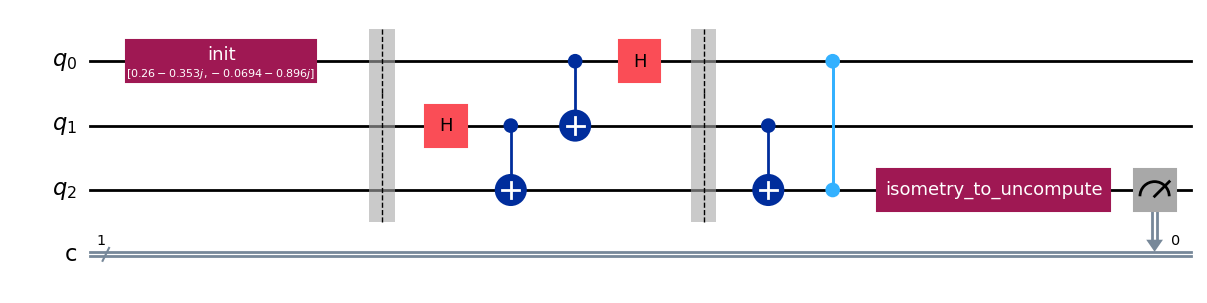

In [55]:
def new_bob_gates(qc,a,b,c):
    qc.cx(b,c)
    qc.cz(a,c)

qc=QuantumCircuit(3,1)
qc.append(init_gate,[0])
qc.barrier()
create_bellstate(qc,1,2)
alice_gates(qc,0,1)
qc.barrier()
new_bob_gates(qc,0,1,2)
qc.append(inv_init_gate,[2])
qc.measure(2,0)
qc.draw('mpl')

In [58]:
service=QiskitRuntimeService()
backend=service.least_busy(operational=True,simulator=False,min_num_qubits=20)
print(f"backend: {backend.name}")

qiskit_runtime_service.__init__:WARNING:2025-12-17 19:57:07,023: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-17 19:57:07,531: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-17 19:57:10,025: Using instance: open-instance, plan: open


backend: ibm_torino


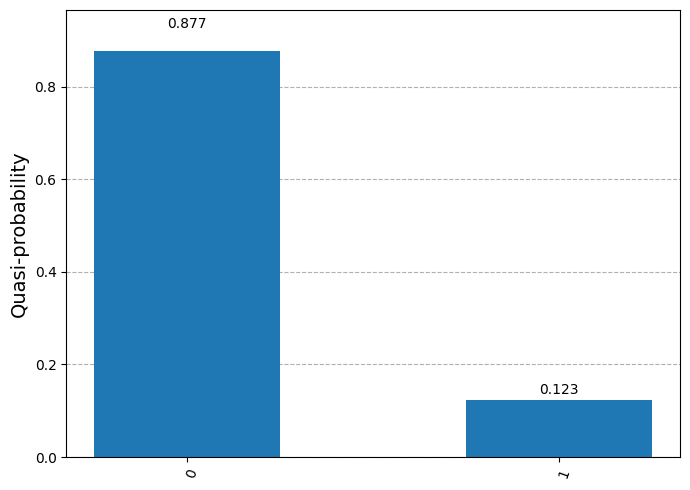

In [63]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2
pm=generate_preset_pass_manager(backend=backend, optimization_level=3)
isa=pm.run(qc)
sampler=SamplerV2(mode=backend)
result=sampler.run([isa]).result()
counts=result[0].data.c.get_counts()
plot_distribution(counts)

In [65]:
def create_bell_pair():
    qc=QuantumCircuit(2)
    qc.h(1)
    qc.cx(0,1)
    return qc

def encode_message(qc,qubit,msg):
    if len(msg) != 2 or not set(msg).issubset({"0","1"}):
        raise ValueError(f"message '{msg}' is invalid")
    if msg[1]=='1':
        qc.x(qubit)
    if msg[0]=='1':
       qc.z(qubit)
    return qc

def decode_msg(qc):
    qc.cx(0,1)
    qc.h(1)
    return qc

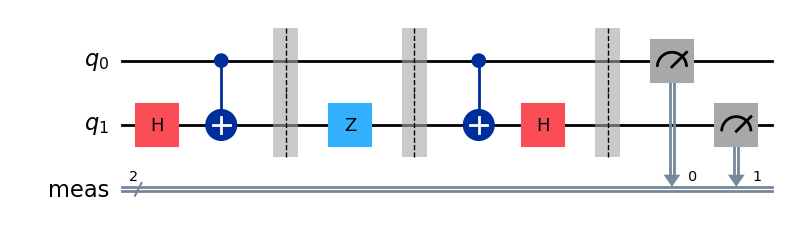

In [69]:
qc=create_bell_pair()
qc.barrier()
encode_message(qc,1,'10')
qc.barrier()
decode_msg(qc)
qc.measure_all()
qc.draw('mpl')

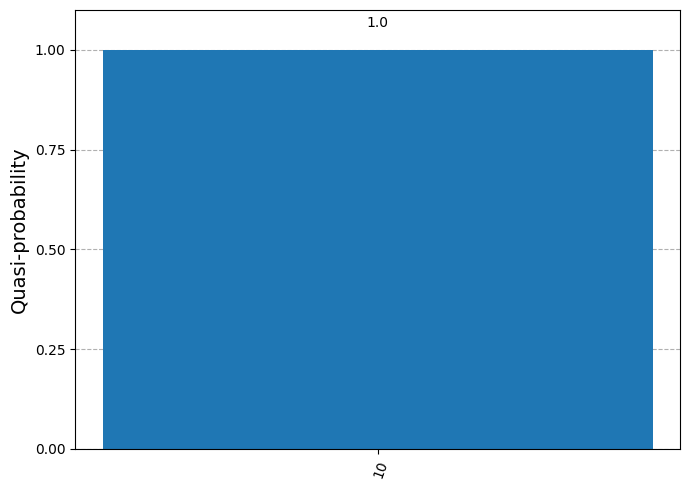

In [70]:
counts=sim.run(qc).result().get_counts()
plot_distribution(counts)

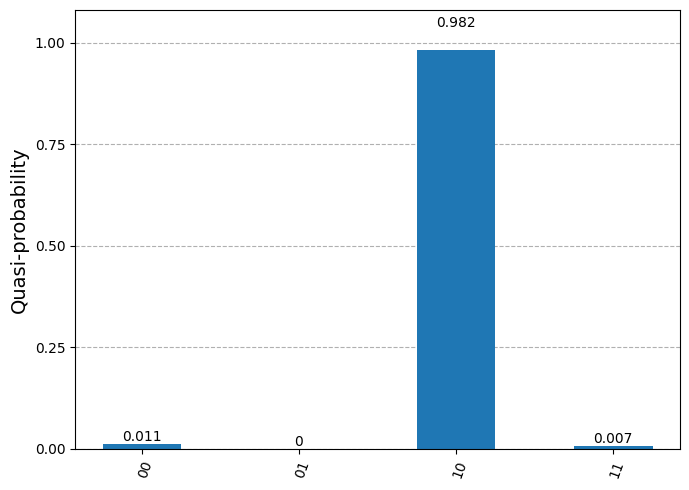

In [71]:
isa=pm.run(qc)
result=sampler.run([isa]).result()
counts=result[0].data.meas.get_counts()
plot_distribution(counts)